## Dự án 01: Xây dựng Raspberry PI thành máy tính cho Data Scientist (PIDS)
## Bài 04. Thử nghiệm Decision tree trên PIDS

##### Người soạn: Dương Trần Hà Phương
##### Website: [Mechasolution Việt Nam](https://mechasolution.vn)
##### Email: mechasolutionvietnam@gmail.com
---

Trong Machine Learning có  rất nhiều phương pháp học sử dụng mô hình học với Xác suất - Thống kê để tìm ra biên quyết định. Một phương pháp nổi bật có thể nhắc đế là [Decision Tree (cây quyết định, viết tắt là DTree)](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/).

DTree có rất nhiều ứng dụng trong các bài toán như: bài toán phân loại (classification), dự đoán (prediction) và khám phá cấu trúc của dữ liệu (Data mining, Data manipulation).

Trong bài này, chúng ta sẽ khám phá và tìm hiểu xem làm cách nào một mô hình có thể đưa ra quyết định trên dataset (tập dữ liệu) Car Evaluation. DTree làm việc với các mệnh đề "if" đơn giản được ghép đôi với nhau, dùng đệ quy để phân tách dữ liệu cho đến khi đạt được trạng thái có thể phân tách dữ liệu.

DTree là một thuật toán tốt cho việc khám phá / khai phá cấu trúc ẩn của dữ liệu. Chúng ta sẽ xây dựng và mô hình hoá dataset Car Evaluation  với bài toán dự đoán là một hàm toàn ánh ([surjective function](https://en.wikipedia.org/wiki/Surjective_function)). Điều đó có nghĩa là với mỗi input thuộc dataset thì chỉ có một và chỉ một output để dự đoán (không bao giờ có một input có hai hay nhiều output). Theo quan điểm của Khoa học dữ liệu, vì tính chất của dataset Car Evaluation, chúng ta không cần sử dụng tập dữ liệu Test cũng nhưng không cần dùng [Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). Do đó, lỗi chungs ta thu được sau khi mô hình hoá dataset cũng chính là lỗi thực nghiệm.

## Giới thiệu Dataset Car Evaluation

Xem thông tin chi tiết tại: http://archive.ics.uci.edu/ml/datasets/Car+Evaluation

### Tổng quan

Dataset Car Evaluation được lấy từ một mô hình phân cấp đơn giản, được phát triển bởi M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). Mô hình đánh giá xe theo cấu trúc như sau:

- CAR car acceptability:
  - PRICE overall price:
    - **buying** buying price
    - **maint** price of the maintenance
  - TECH technical characteristics:
    - COMFORT comfort:
      - **doors** number of doors
      - **persons** capacity in terms of persons to carry
      - **lug_boot** the size of luggage boot
    - **safety** estimated safety of the car

Các attribute (thuộc tính) là các chữ được **in đậm** của cấu trúc trên.

### Attributes, instances, and Class Distribution

Số lượng thuộc tính: 6

Thuộc tính ẩn: không có

| Attribute  | Values |
|------------|--------|
| buying     | v-high, high, med, low |
| maint      | v-high, high, med, low |
| doors      | 2, 3, 4, 5-more |
| persons    | 2, 4, more |
| lug_boot   | small, med, big |
| safety     | low, med, high |

Số lượng cá thể: 1728 (Các cá thể hoàn toàn bao trùm không gian thuộc tính)

| class | N | N[%] |
|---|---|---|
| unacc | 1210 | 70.023 % |
| acc | 384 | 22.222 % |
| good | 69 | 3.993 % |
| v-good | 65 | 3.762 % |


## Bắt đầu nào !!!

Đầu tiên, chúng ta cần cài đặt thư viện để có thể trực quan hoá cây quyết định, đó là thư viện `GraphViz`. Download thư viện `GraphViz` tại [ĐÂY](https://packages.debian.org/stretch/armhf/graphviz/download), bạn có thể chọn bất kì địa chỉ nào bạn muốn.
Tiếp theo, chúng ta sẽ cái phiên bản Python của `GraphViz` là `pydot` với câu lệnh trong Terminal:

>`sudo pip3 install pydot`

Sau đó, chúng ta khai báo các thư viện cần thiết như: sklearn (load dataset, training), matplotlib (trực quan hoá kết quả), pydot, . . . 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import tree
import pydot

from io import StringIO
import os

### Định nghĩa các đặc trưng (features) và tiền xử lý dataset

Chúng ta sẽ tiền xử lý các thuộc tính như sử dụng integer index (linear) để biểu thị giá trị của thuộc tính, cũng như sử dụng [one-hot encoding](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/) cho mỗi giá trị của thuộc tính như là một đặc trưng mới. Điều này tuy nhập nhằng nhưng sẽ giúp Dtree của chúng ta nhỏ hơn.

##### Định nghĩa các đặc trưng và đọc dữ liệu

In [2]:
# The integer values for features will take
# a range from 0 to n-1 in the lists of possible values:
input_labels = [
    ["buying", ["vhigh", "high", "med", "low"]],
    ["maint", ["vhigh", "high", "med", "low"]],
    ["doors", ["2", "3", "4", "5more"]],  # Here indexes are not real values
    ["persons", ["2", "4", "more"]],
    ["lug_boot", ["small", "med", "big"]],
    ["safety", ["low", "med", "high"]],
]

class_names = ["unacc", "acc", "good", "vgood"]

# Load data set
data = np.genfromtxt(os.path.join('data', 'car.data'), delimiter=',', dtype="U")
data_inputs = data[:, :-1]
data_outputs = data[:, -1]

##### Định nghĩa 2 hàm xử lý dữ liệu

In [3]:
# Convert each feature's string to a flattened one-hot array.
def str_data_to_one_hot(data, input_labels):
    X_int = LabelEncoder().fit_transform(data.ravel()).reshape(*data.shape)
    X_bin = OneHotEncoder().fit_transform(X_int).toarray()
      
    feature_names = []
    for a in input_labels:
        key = a[0]
        for b in a[1]:
            value = b
            feature_names.append("{}_is_{}".format(key, value))

    return X_bin, feature_names

# Convert each feature's string to an integer index
def str_data_to_linear(data, input_labels):
    X_lin = np.array([[
        input_labels[a][1].index(j) for a, j in enumerate(i)
    ] for i in data])
    
    # Integer feature indexes will range
    # from 0 to n-1 from indexes in the label list:
    feature_names = [i[0] + "_index" for i in input_labels]
    
    return X_lin, feature_names

##### Tiền xử lý dữ liệu

In [4]:
# Take both one-hot and linear versions of input features: 
X_one_hot, feature_names_one_hot = str_data_to_one_hot(data_inputs, input_labels)
X_linear_int, feature_names_linear_int = str_data_to_linear(data_inputs, input_labels)

# Put that together:
X = np.concatenate([X_one_hot, X_linear_int], axis=-1)
feature_names = feature_names_one_hot + feature_names_linear_int

# Outputs use indexes, this is not one-hot:
integer_y = np.array([class_names.index(i) for i in data_outputs])

print("Data set's shape,")
print("X.shape, integer_y.shape, len(feature_names), len(class_names):")
print(X.shape, integer_y.shape, len(feature_names), len(class_names))

Data set's shape,
X.shape, integer_y.shape, len(feature_names), len(class_names):
(1728, 27) (1728,) 27 4


### Huấn luyện một cây quyết định đơn giản

Đầu tiền, hãy định nghĩa một vài hyperparameters như: độ sâu của cây (max_depth)

In [7]:
max_depth = 6
clf = tree.DecisionTreeClassifier(max_depth=max_depth)
clf = clf.fit(X, integer_y)

print("Decision tree trained!")
accuracy = clf.score(X, integer_y)
print("Errors:", 100 - accuracy * 100, "%")
print("Accuracy:", accuracy * 100, "%")

Decision tree trained!
Errors: 6.539351851851848 %
Accuracy: 93.46064814814815 %


### Vẽ đồ thị và lưu kết quả Cây quyết định

In [8]:
# Plot and save our scikit-learn tree.
def plot_n_save(clf, class_names, tree_name):
    graph_save_path = os.path.join(
        "imgs", 
        "{}".format(tree_name)
    )

    tree.export_graphviz(clf, out_file="{}.dot".format(graph_save_path))
    
    dotfile = StringIO()
    tree.export_graphviz(
        clf, out_file=dotfile,
        feature_names=feature_names, class_names=class_names,
        filled=True, rotate=True
    )
    pydot.graph_from_dot_data(dotfile.getvalue())[0].write_png("{}.png".format(graph_save_path))

# Plot our simple tree:
plot_n_save(clf, class_names, tree_name="simple_tree")

![simple tree](imgs/simple_tree.png)

### Vẽ đồ thị biểu diễn tầm quan trọng của các đặc trưng

Lưu ý ở đây rằng nó là tầm quan trọng của các đặc trưng với cây quyết định đơn giản vừa xây dựng ở trên. Một cây quyết định đầy đủ chắc chắn sẽ bao gồm nhiều đặc trưng / thuộc tính, và với tỷ lệ khác nhau.

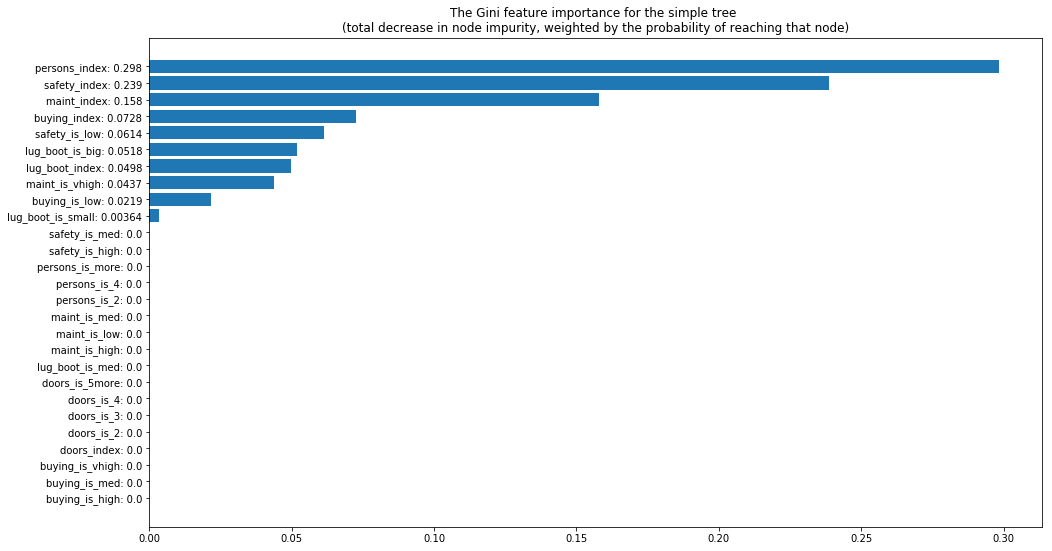

In [9]:
def feature_importance_chart(clf, classifier_name, feature_names):
    sorted_feature_importances, sorted_feature_names = (
        zip(*sorted(zip(clf.feature_importances_, feature_names)))
    )
    plt.figure(figsize=(16, 9))
    plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances)
    plt.yticks(
        range(len(sorted_feature_importances)),
        ["{}: {:.3}".format(a, b) for a, b in zip(sorted_feature_names, sorted_feature_importances)]
    )
    plt.title("The Gini feature importance for the {} \n"
              "(total decrease in node impurity, weighted by the "
              "probability of reaching that node)".format(classifier_name))
    plt.show()

feature_importance_chart(clf, "simple tree", feature_names)

### Nào ! Bắt tay vào xây dựng một cây quyết định phức tạp nào

<p align="center">
  <a href="http://theinceptionbutton.com/" ><img src="deeper.jpg" /></a>
</p>

In [10]:
max_depth = None  # Full depth
clf = tree.DecisionTreeClassifier(max_depth=max_depth)
clf = clf.fit(X, integer_y)

print("Decision tree trained!")
accuracy = clf.score(X, integer_y)
print("Errors:", 100 - accuracy * 100, "%")
print("Accuracy:", accuracy * 100, "%")

Decision tree trained!
Errors: 0.0 %
Accuracy: 100.0 %


### A plot of the full tree

In [11]:
plot_n_save(clf, class_names, tree_name="complex_tree")

![complex tree](imgs/complex_tree.png)

### Cuối cùng, đồ thị đầy đủ thể hiện tầm quan trọng của các đặc trưng

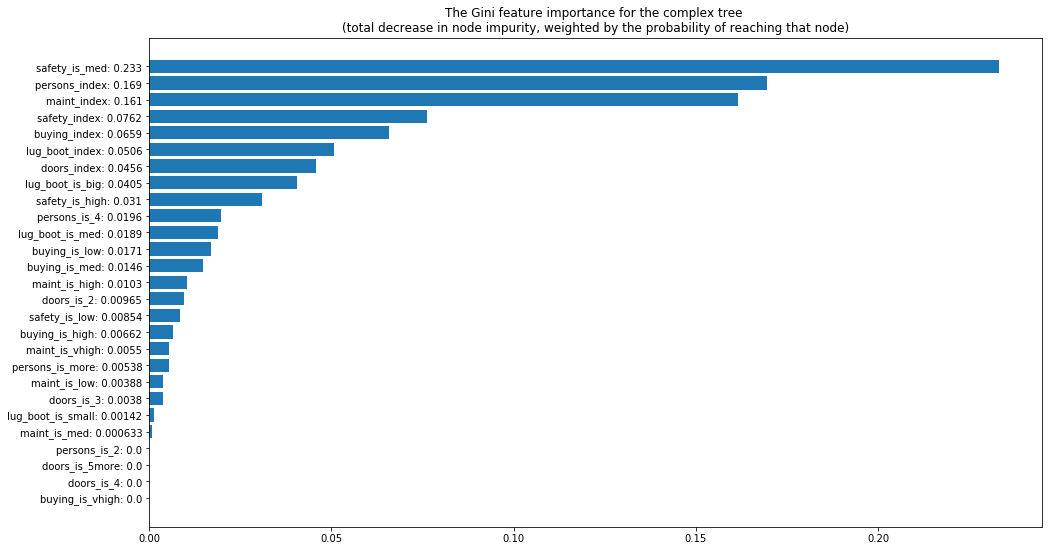

In [12]:
feature_importance_chart(clf, "complex tree", feature_names)

## Kết luận

Tóm lại, chúng ta đã đạt được kết quả phân loại tốt và có thể giải thích các kết quả đó một cách trực quan, tự động.

Phương pháp Decision Trees có thể hữu ích trong việc thiết kế ngược một hệ thống hiện có, chẳng hạn như một hệ thống cũ đã được mã hóa đặc biệt và các nhân viên đã mã hóa nó không còn làm việc nữa. Kỹ thuật này cũng có thể được sử dụng để khai thác dữ liệu, thu thập thông tin kinh doanh và thông tin chi tiết từ dữ liệu.

## Tham khảo
[1] [Discovering structure behind data](https://github.com/Vooban/Decision-Trees-For-Knowledge-Discovery)

---
Nếu có thắc mắc hoặc góp ý, các bạn hãy comment bên dưới để bài viết có thể được hoàn thiện hơn. 
Xin cảm ơn,

Hà Phương - Mechasolution Việt Nam.